## Packages and modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from collections import namedtuple
# Disable warnings 
import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

In [2]:
def reset_global_random_seed():
    # fix seed cause reproducable result
    seed = 1997118
    random.seed(seed)
    np.random.seed(seed)

# 💁‍♂️ getting help
For **getting help** about parameters and return results:

`help(function_you_dont_know)`  
or use numpy info function   
`np.info(function_you_dont_know)`

# Modeling Section

- **Neuron**
    - integrate
    - generate_config
- **Utils**
    - clamp
    - soft_bound_Ap
    - soft_bound_An
    - hard_bound
    - soft_bound
- **Connection**
    - full alias for full_connectivity
    - fixedNNP alias for fixed_number_of_presynaptics_parents_connectivity
    - fixedCp alias for fixed_coupling_probability_connectivity
    - set_relations
- **Learning**
    - stdp
- **Population**
    - activate
    - transmit_spike
    - check_activition
 
 Global
 - **step**

In [3]:
class Neuron:
    """ Neuron Utility handlers """
    @staticmethod
    def integrate(U, I, dt, config):
        """
            Calculate next potentials list based on last potentials and Currents input which neurons get
            Cause numpy brodcasting ability, functions may work correct for single entry for ndarrays 

            Keyword arguments:
            U -- potentials array <numpy.ndarray>
            I -- current stands for internat and extrenal currents which every neurons recives <numpy.ndarray>
            dt -- time step for each step <float>
            config -- A matrix containg configuration for each of neurons <numpy.ndarray>
                      it must [u_rest, R, threshold, tau] it use array keyword referencing.
            
            return:
            a tuple that contains (potentials, spikedActivity)
            potentials -- new potentials calculated based on Leaky integrated and fire dynamics <numpu.ndarray>
            spikedActivity -- boolean array which shows wheter neuron spiked in this step or not <numpy.ndarray>
        """
        u_rest = config['u_rest']
        potentials = U + (u_rest - U + config['R'] * I) * (dt / config['tau'])
        spiked = potentials >= config['threshold']
        potentials[spiked] = u_rest
        return potentials, spiked

    @staticmethod
    def generate_config(tau=5, resistor=5, threshold=-65, uRest=-70, size=None, noise=None):
        """ 
            generate configuration for variables make them noisy in if args presented

            Keyword arguments:
            tau -- time constant for decays (default=5)
            resistor -- (default=5)
            threshold -- (default=-65)
            uRest -- (default=-70)
            size -- size of configuration (default=None)
            noise -- setup for adding noise to configuration, make them not be exactly the same 
                    { size, mu, sigma } (default=None)
                    mu -- mean of distribution (default=0)
                    sigma -- standrad variation of distribution (default=1)

            return: configurations

            TODO: accept None in noise to prevent gauusain noise around specifi varibale
            TODO: accpet diffrent configs for noise parameter, make it possible to have diffrent noise for diffrent configs 
            TODO: move noise to higger level use case, and keep pop homogenous 
            TODO: setup dtype optimization for lower memory allocation  
        """
        if noise is None or size is None:
            return np.array((tau, resistor, threshold, uRest), dtype=[('tau', 'f8'), ('R', 'f8'), ('threshold', 'f8'), ('u_rest', 'f8')])

        def n(v): return v + np.random.normal(noise.get('mu', 0),noise.get('sigma', 1), size)
        return {'tau': n(tau), "R": n(resistor), "threshold": n(threshold), 'u_rest': uRest}

In [4]:
class Utils:
    @staticmethod
    def clamp(value, minimum=None, maximum=None):
        """
            Clamp entry value between specified bound, no clamp will be done if bound is not specifeid
            Cause numpy brodcasting ability, functions may work correct for single entry for ndarrays
            Do it inplace and will change entry value

            Keyword arguments:
            value -- Values which gonna be clamped <numpy.ndarray>
            minimum -- lower bound (default=None)
            maximum -- upper bound (default=None)
            
            updated value can be used
        """
        if (minimum is not None):
            value[value < minimum] = minimum
        if (maximum is not None):
            value[value > maximum] = maximum

    @staticmethod
    def soft_bound_Ap(w, w_max=1, nu_positive=0.3):
        """
            soft bound function for updating Weigths by A+(amplitude parameter) in stdp learnging

            Keyword arguments:
            w -- weights <numpy.ndarray>
            w_max -- maximum value can w reach, it cause lower update in for close weigths (default=1)
            nu_positive -- rating parameters for updaing weigths (deafult=0.3)

            return: (w_max - w) * η+
        """
        return (w_max - w) * nu_positive

    @staticmethod
    def soft_bound_An(w,  w_min=0, nu_negative=0.2):
        """
            soft bound function for updating Weigths by A-(amplitude parameter) in stdp learnging

            Keyword arguments:
            w -- weights <numpy.ndarray>
            nu_negative -- rating parameters for updaing weigths (deafult=0.2)

            return: (w - w_min) * η-
        """
        return (w - w_min) * nu_negative

    @staticmethod
    def hard_bound(w, w_min, w_max):
        """ Hard bound helper function for Weights """
        w[w < w_min] = 0
        w[w > w_max] = 0

    @staticmethod
    def soft_bound(w, w_max, gamma, beta):
        """ Soft bound helper function for Weights """
        return gamma * (w_max - w) ** beta

In [5]:
class Connection:
    """ 
        Connect population A to population B with connection_type strategy
            full or full_connectivity,
            fixedCP or fixed_coupling_probability_connectivity,
            fixedNPP or fixed_number_of_presynaptics_parents,

        Keyword arguments:
        A -- size of pre-population <int>
        B -- size of post-pospulation <int>
        ------------------------------------
        p -- coupling_probability (default=0.1)
        J0 -- TODO:
        r0 -- TODO:

        TODO: For illiminate performance issue it doesn't connect neurons until calling @method for comp
        TODO: Documentaion must be added in this case
    """
    @staticmethod
    def full_connectivity(A, B, p=1, J0=10, r0=1, wMax=None, wMin=None):
        pre_indexes, post_indexes = range(A), range(B)
        C = p * A  # p * N
        assert C != 0, 'Check size of your pre-poulation size, or increase p (No Devision by Zero)'
        μ, σ = J0/C, r0/math.sqrt(C)
        normal = np.random.normal
        relations = []
        for pre in pre_indexes:
            for post in post_indexes:
                relations.append((pre, post, normal(μ, σ)))
        connections = Connection.set_relations(relations)
        if (wMin is not None or wMax is not None):
            Utils.clamp(connections['w'], wMin, wMax)
        return connections
    

    @staticmethod
    def fixed_coupling_probability_connectivity(A, B, p=0.1, J0=10, r0=1, wMax=None, wMin=None):
        pre_indexes, post_indexes = range(A), range(B)
        CA = p * A
        assert CA != 0, 'Check size of your pre-poulation size, or increase p (No Devision by Zero)'
        CB = p * B
        assert CB != 0, 'Check size of your post-poulation size, or increase p (No Devision by Zero)'
        μ, σ = J0/CB, r0/math.sqrt(CB)
        normal = np.random.normal
        relations = []
        for pre in np.random.choice(pre_indexes, int(CA), replace=False):
            for post in np.random.choice(post_indexes, int(CB), replace=False):
                relations.append((pre, post, normal(μ, σ)))
        connections = Connection.set_relations(relations)
        if (wMin is not None or wMax is not None):
            Utils.clamp(connections['w'], wMin, wMax)
        return connections

    @staticmethod
    def fixed_number_of_presynaptics_parents_connectivity(A, B, p=0.1, J0=10, r0=1, wMax=None, wMin=None):
        pre_indexes, post_indexes = range(A), range(B)
        C = p * A
        assert C != 0, 'Check size of your pre-poulation size, or increase p (No Devision by Zero)'
        μ, σ = J0/C, r0/math.sqrt(C)
        normal = np.random.normal
        relations = []
        for post in post_indexes:
            for pre in np.random.choice(pre_indexes, int(C), replace=False):
                relations.append((pre, post, normal(μ, σ)))
        connections = Connection.set_relations(relations)
        if (wMin is not None or wMax is not None):
            Utils.clamp(connections['w'], wMin, wMax)
        return connections

    @staticmethod
    def set_relations(relations):
        """
            Keyword arguments:
            relations -- relation connections <iterator with (pre_index, post_index, weight_for_connection)>
            return ndarray < pre, post, w >
            pre -- index of pre synaptic neurons
            post -- index of post synaptic neurons
            w -- weight for connections
        """
        return np.array(relations, dtype=[('pre', np.uint16), ('post', np.uint16), ('w', np.float64)])

    # short hand for connectivities
    full = full_connectivity.__func__
    fixedCP = fixed_coupling_probability_connectivity.__func__
    fixedNPP = fixed_number_of_presynaptics_parents_connectivity.__func__

In [6]:
class Learning:
    @staticmethod
    def stdp(t_pre, t_post, W,  **config):
        Δt = t_post - t_pre
        Δw = np.empty_like(Δt)
        # https://books.google.co.uk/books?id=GCguDwAAQBAJ&pg=PA92&lpg=PA92&dq=stdp+algorithm+pseudocode&source=bl&ots=thYibFM0y3&sig=ACfU3U2vYzpdYZsEjpfC0nJB128J0U3GVw&hl=en&sa=X&redir_esc=y#v=onepage&q=stdp%20algorithm%20pseudocode&f=false

        Δtp = Δt >= 0
        if np.any(Δtp):
            Ap = config.get('Ap', Utils.soft_bound_Ap)
            τp = config.get('taup', 0.03)
            ηp = config.get('etap', 0.03)
            w_max = config.get('wMax', 1)
            Δw[Δtp] = Ap(W[Δtp], w_max, ηp) * np.exp(-Δt[Δtp] / τp)

        Δtn = Δt < 0
        if np.any(Δtn):
            An = config.get('An', Utils.soft_bound_An)
            ηn = config.get('etan', 0.02)
            τn = config.get('taun', 0.02)
            w_min = config.get('wMin', 0)
            Δw[Δtn] = -An(W[Δtn], w_min, ηn) * np.exp(Δt[Δtn] / τn)

        Δw[np.isnan(Δw)] = 0
        Δw[np.isinf(Δw)] = 0
        Δt[np.isnan(Δt)] = -np.inf
        return Δw, Δt

In [7]:
class Population:
    """ 
        Gonna Handle homogenous population 

        Keyword argumetns:
        neuron -- Neuronal model LIF is implemented see:Neuron class
        neuron_configs -- dictionary that will spread to Neuron.generate_config function, see generate_config doc.
        **config -- extra aruments such as 
            timeStep -- dt <float> (default=0.1)
            hasInhibition -- <boolean> (deafult=False)
            duration --duration of process used for generating time series for process <float> (default=5)
            size -- number of neurons in this populations <int> (default=1000)
    """
    def __init__(self, neuron, neuron_configs={}, **configs):
        self.dt = configs.get('timeStep', 0.1)
        duration = configs.get('duration', 5)
        self.time_series = np.arange(0, duration, self.dt)
        self.size = configs.get('size', 1000)
        self.isi = (-1) ** int(configs.get('hasInhibition', False))

        self.potentials_series = np.empty((self.size, self.time_series.size))
        self.neuron_configs = Neuron.generate_config(
            **neuron_configs, size=self.size)
        self.last_spiked = np.ones(self.size)
        self.last_spiked.fill(np.nan)

        self.I_internal = np.zeros(self.size)
        # minus epsilon for not firing in first time
        self.potentials_series[:, 0] = self.neuron_configs['u_rest'] - 0.1

    def activate(self, t, Iext=30.0):
        """ 
            Activate a population for one step 
            
            Keyword arguments:
            t -- time index 
            Iext --  (deafult=30)

            return: spiked_map
            
            TODO: need I_ext calculation from static fixed I ~ N(μ, σ), or separated for each individual
            TODO: I is now constant and not configured for pop (@critical) 
        """
        assert 1 <= t < self.time_series.size, 'Please Enter an integer belongs to [1, duration/dt) range as an index.'
        assert isinstance(
            Iext, float) or Iext.shape == self.I_internal.shape, 'Please Enter an integer belongs to [1, duration/dt) range as an index.'
        I = self.I_internal + Iext
        ut, spiked = Neuron.integrate(
            self.potentials_series[:, t - 1], I, self.dt, self.neuron_configs)
        self.last_spiked[spiked] = self.time_series[t]
        self.potentials_series[:, t] = ut
        return spiked

    def transmit_spike(self, indices=None, weights=None, isi=1, decay=None):
        """
            Transmit weights update effect to connected populations
            Keyword arguments:
            indeces -- indeces of neuron which going to update (deafult=None)
            weights -- weights of connections related to indeces (deafult=None)
            isi -- shows that updates are from inhibitory pop or excititory pop
            decay -- amount of decay, usefull when reseting make learning time long

            reset or reduce Tranmistion near to its initial zero where one of indeces or weights are not passed to function
        """
        if indices is None or weights is None:
            if decay is None:
                self.I_internal = np.zeros(self.size)
            else:
                self.I_internal *= decay
        else:
            self.I_internal[indices] += isi * weights

    def check_activition(self, I, t=-1):
        return Neuron.integrate(self.potentials_series[:, t], self.I_internal+I, self.dt, self.neuron_configs)

###  1️⃣) First Question ❓ 

In [25]:
def step(A, B, connections, target, t, I, stdp_config, modulated, dopamin, trace=[], delay=0):
    is_pre = target == 'pre'
    # PRE-POST::PRE/POST-PRE::POST SYNAPTIC FIRING -> WEIGHT UPDATES
    target_pop = A if is_pre else B
    spikes = target_pop.activate(t, I)
    activated_pop = np.where(spikes)[0]
    if not activated_pop.size:
        return
    for idx in activated_pop:
        involved = connections[connections[target] == idx]

        dw, dt = Learning.stdp(
            A.last_spiked[involved['pre']], B.last_spiked[involved['post']], involved['w'], **stdp_config)

        c = modulated['c']
        c += -c/modulated['tau_c']  * target_pop.dt
        c[connections[target] == idx] += dw * target_pop.dt
        ds = (c * dopamin if isinstance(dopamin, (int, float)) else c*dopamin) * target_pop.dt
        connections['w'][connections[target] == idx] += ds[connections[target] == idx]

        if delay != 0:
            # PSP 
            update = target_pop.potentials_series[idx,t-delay] - target_pop.neuron_configs['u_rest']
            connections['w'][connections[target] == idx] *= update
            
        Utils.hard_bound(connections['w'],stdp_config['wMin'], stdp_config['wMax'])
        trace.append((t, dw, dt, connections['w'].copy(), target.upper(), dopamin.copy(), spikes))
        if is_pre:
            B.transmit_spike(involved['post'], connections[connections['pre'] == idx]['w'], A.isi)

###  1️⃣) First Question ❓ 

In [26]:
def random_pattern(size=10):
    pattern = np.zeros(size)
    pattern[np.random.randint(0, size)] = 1
    return pattern

def get_I(pattern, nth, maximum_current=15000.0):
    return np.where(pattern == nth, maximum_current, 0)


""" delayed based current
    ellipsis = t, d => u[t-d]-u_rest
    W*ellipsis(curretnTime, delay)    
"""
def get_pattern_effect(pattern, src, dest, connections, t=-1):
    accumulated_weight_sum = np.zeros(dest.size, dtype=np.float64)
    for nth in range(int(max(pattern))):
        # based on entry time (default last) 
        ut, spiked = src.check_activition(get_I(pattern, nth+1))
        indices = np.arange(0, src.size, 1)[spiked]
        for idx in indices:
            involved = connections[connections['pre'] == idx]
            accumulated_weight_sum[involved['post']] += involved['w'] * (dest.potentials_series[:, t]-dest.neuron_configs['u_rest'])
    return accumulated_weight_sum

def spike_plotter(x, y, xlabel, ylabel, title, c=None, ax=None, save=False):
    if ax is None:
        _, ax = plt.subplots()
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
    ax.scatter(x, y, s=1, c=c)
    if save:
        ax.savefig(f'{title}.png')

In [27]:
def reward_punishment(post_spikes, dopamin, pattern, c0, c1):
    # punish
    if not post_spikes:
        dopamin *= 0.9
    
    spikes = post_spikes[-1][-1]
    is_post = post_spikes[-1][-3] == 'POST'
    if is_post:
        if pattern==10 and spikes[0] and not spikes[1]:
            dopamin *= 1.1
        else:
            dopamin[c0] *= 0.9

        if pattern==11 and spikes[1] and not spikes[0]:
            dopamin *= 1.1
        else:
            dopamin[c1] *= 0.9
    
    if len(post_spikes) == 1:
        return
    
    spikes = post_spikes[-2][-1]
    is_post = post_spikes[-2][-3] == 'POST'

    if is_post:
        if pattern==10 and spikes[0] and not spikes[1]:
            dopamin *= 1.1
        else:
            dopamin[c0] *= 0.9

        if pattern==11 and spikes[1] and not spikes[0]:
            dopamin *= 1.1
        else:
            dopamin[c1] *= 0.9

In [28]:
first_pattern  = np.array((2, 1, 0, 0, 0, 0, 0, 0, 1, 2))
second_pattern = np.array((2, 1, 2, 1, 3, 1, 2, 1, 2, 1))

size = {"first": 200, "second": 190, "start": 15, "middle": 200, "end": 0}
learnable_patterns = [first_pattern for i in range(size['first'])]
learnable_patterns.extend([second_pattern for i in range(size['second'])])
learnable_patterns.extend([random_pattern() for i in range(size['middle'])])
random.shuffle(learnable_patterns)
patterns = [random_pattern() for i in range(size['start'])]
patterns.extend(learnable_patterns)
patterns.extend([random_pattern() for i in range(size['end'])])
del learnable_patterns

def pattern_type(pattern):
    if np.all(pattern - first_pattern):
        return 10
    if np.all(pattern - second_pattern):
        return 11
    return int(max(pattern))


def many2many(
    src_size, 
    dest_size, 
    config = {'timeStep': 0.01},
    stdp_config = {'wMax': 25, 'wMin': 0, 'taup': 8,'taun': 6, 'etap': 0.04, 'etan': 0.05},
    src_neuron_configs = {'tau': 5, 'resistor': 5,'threshold': -60, 'uRest': -75, 'noise': {'mu': 0, 'sigma': 2}},
    dest_neuron_configs = {'tau': 5, 'resistor': 5, 'threshold': -60, 'uRest': -75, 'noise': {'mu': 0, 'sigma': 5}},
    patterns=patterns, 
):
    reset_global_random_seed()
    config['duration'] = (1+sum(max(pattern) for pattern in patterns)) * config['timeStep']
    src  = Population(Neuron, src_neuron_configs, size=src_size, hasInhibition=False, **config)
    dest = Population(Neuron, dest_neuron_configs,size=dest_size,hasInhibition=False, **config)
    
    connections = Connection.full(src.size, dest.size, J0=10,r0=5, wMax=stdp_config['wMax'], wMin=stdp_config['wMin'])
    synaptic_tag = np.ones_like(connections['w']) 
    modulated = {'c': synaptic_tag, 'tau_c': 5}
    dopamin = synaptic_tag.copy()
    c0_connections = connections['post'] == 0
    c1_connections = connections['post'] == 1

    
    t = 1
    many2many_temoral_returned_result = { 'initialW': connections['w'].copy(), 'patterns':[] }
    dw_dt = []
    dest.transmit_spike()
    for pattern in patterns:
        dest.transmit_spike(decay=0.9)
        
        plot_hash = 10 if np.all(pattern-first_pattern==0) else 11 if np.all(pattern-second_pattern==0) else np.argmax(pattern) 
        many2many_temoral_returned_result['patterns'].append((t,plot_hash))
        
        for nth in range(int(max(pattern))):
            step(src, dest, connections, 'pre', t, get_I(pattern, nth+1), stdp_config, modulated, dopamin, dw_dt)
            t += 1


        step(src, dest, connections, 'post',  t-1, 
             get_pattern_effect(pattern, src, dest, connections, t-1), 
             stdp_config, modulated, dopamin, dw_dt)

        last2Spikes = dw_dt[-2:]
        reward_punishment(last2Spikes, dopamin, pattern_type(pattern), c0_connections, c1_connections)

    many2many_temoral_returned_result['finalW'] = connections['w'].copy()
    many2many_temoral_returned_result['dw_dt'] = dw_dt
    return many2many_temoral_returned_result

dic = many2many(10,2)

In [18]:
def print_diff(A,B, title=None):
    if title is not None:
        print(f"=== {title} ===")
    print("initial:", " ".join(map(lambda x: f"{x:<5}", np.round(A,2))))
    print("final  :" , " ".join(map(lambda x: f"{x:<5}", np.round(B,2))))
    print("diff   :" , " ".join(map(lambda x: f"{x:<5}", np.round(B-A,2))))
    
print_diff(dic['initialW'], dic['finalW'], 'Weights Update')

=== Weights Update ===
initial: 1.14  1.64  0.0   2.39  0.0   3.64  0.0   0.0   3.07  0.17  0.0   1.19  2.83  1.98  0.0   0.84  2.23  0.12  3.65  0.42 
final  : 1.21  1.74  0.06  2.48  0.04  3.68  0.07  0.0   3.12  0.25  0.07  1.3   2.87  2.06  0.07  0.93  2.28  0.21  3.7   0.5  
diff   : 0.06  0.1   0.06  0.09  0.04  0.04  0.07  0.0   0.05  0.08  0.07  0.11  0.05  0.08  0.07  0.1   0.06  0.09  0.05  0.08 


In [19]:
def pre_post_spikes(dw_dt, title, xlabel='t', ylabel='spikes'):
    pre_spiked, post_spiked = {'t':[], 's':[]}, {'t':[], 's':[]}
    for dw_dt_instance in dw_dt:
        if dw_dt_instance[4]=='PRE':
            pre_spiked['t'].append(dw_dt_instance[0])
            pre_spiked['s'].append(np.where(dw_dt_instance[-1], np.arange(1,11,1), -1).tolist())
        else:
            post_spiked['t'].append(dw_dt_instance[0])
            post_spiked['s'].append(np.where(dw_dt_instance[-1], np.arange(1,3,1), -1).tolist())

    pre_spiked['s'] = np.array(pre_spiked['s'])
    pre_spiked['t'] = np.array(pre_spiked['t'])

    post_spiked['s'] = np.array(post_spiked['s'])
    post_spiked['t'] = np.array(post_spiked['t'])
    # ----------------------------------------------------------------
    fig, axes = plt.subplots(1,2, figsize=(10, 5))
    if (pre_spiked['s'].size != 0):
        for i in range(10):
            spike_plotter(pre_spiked['t'], pre_spiked['s'][:, i], 
                          xlabel=xlabel, ylabel=ylabel, 
                          title=f"{title} (PRE-Synaptics)",
                          ax=axes[0])
    
    if (post_spiked['s'].size != 0):
        for i in range(2):
            spike_plotter(post_spiked['t'], post_spiked['s'][:, i], 
                          xlabel=xlabel, ylabel=ylabel, 
                          title=f"{title} (POST-Synaptics)",
                          ax=axes[1])

    fig.tight_layout(pad=2.0)    

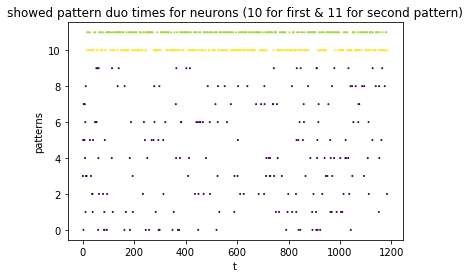

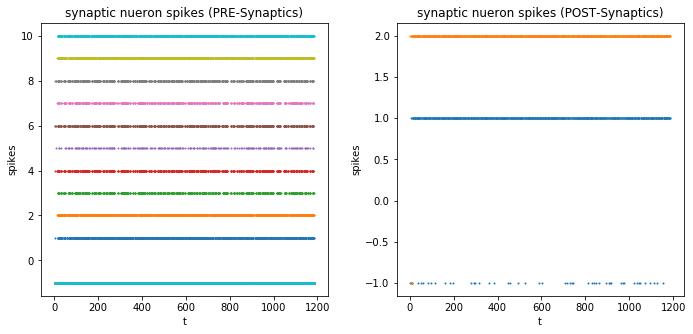

In [20]:
fig, ax = plt.subplots(1,1)
x= np.array(dic['patterns'])
c = x[:,1].copy()
c[c<10] = 0
c[c==10]=14
c[c==11]=12
spike_plotter(x[:,0], x[:,1], 
              xlabel='t', ylabel='patterns', 
              title="showed pattern duo times for neurons (10 for first & 11 for second pattern)", 
              c=c, ax=ax)
# -----------------------------------------------------------------------------------------------
pre_post_spikes(dic['dw_dt'], title="synaptic nueron spikes")

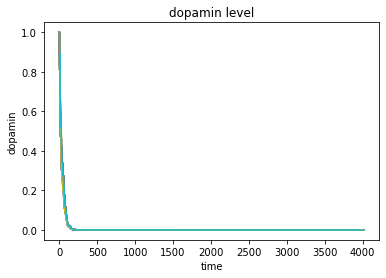

In [40]:
dopamin = np.array([d[-2] for d in dic['dw_dt']])
_, ax = plt.subplots(1,1)
plt.plot(dopamin)
ax.set(xlabel='time', ylabel='dopamin', title='dopamin level')
plt.show()

###  2️⃣) Second Question ❓ 

In [16]:
first_pattern  = np.array((2, 1, 0, 0, 0, 0, 0, 0, 1, 2))
second_pattern = np.array((2, 1, 2, 1, 3, 1, 2, 1, 2, 1))

size = {"first": 200, "second": 190, "start": 15, "middle": 200, "end": 0}
learnable_patterns = [first_pattern for i in range(size['first'])]
learnable_patterns.extend([second_pattern for i in range(size['second'])])
learnable_patterns.extend([random_pattern() for i in range(size['middle'])])
random.shuffle(learnable_patterns)
patterns = [random_pattern() for i in range(size['start'])]
patterns.extend(learnable_patterns)
patterns.extend([random_pattern() for i in range(size['end'])])
del learnable_patterns

def many2many2one(  
    srce_size,
    srci_size, 
    dest_size, 
    config = {'timeStep': 0.01},
    stdp_config_ei = {'wMax': 50, 'wMin': 0, 'taup': 8,'taun': 6, 'etap': 0.4, 'etan': 0.5},
    stdp_config_ed = {'wMax': 15, 'wMin': 0, 'taup': 8,'taun': 6, 'etap': 0.04, 'etan': 0.05},
    stdp_config_id = {'wMax': 20, 'wMin': 0, 'taup': 8,'taun': 6, 'etap': 0.04, 'etan': 0.05},

    srce_neuron_configs = {'tau': 5, 'resistor': 5,'threshold': -60, 'uRest': -75, 'noise': {'mu': 0, 'sigma': 2}},
    srci_neuron_configs = {'tau': 5, 'resistor': 5,'threshold': -60, 'uRest': -75, 'noise': {'mu': 0, 'sigma': 1}},
    dest_neuron_configs = {'tau': 5, 'resistor': 5, 'threshold': -60, 'uRest': -75, 'noise': {'mu': 0, 'sigma': 5}},
    patterns=patterns, 
):
    reset_global_random_seed()
    config['duration'] = (1+sum(max(pattern) for pattern in patterns)) * config['timeStep']
    srce  = Population(Neuron, srce_neuron_configs, size=srce_size, hasInhibition=False, **config)
    srci  = Population(Neuron, srci_neuron_configs, size=srci_size, hasInhibition=True, **config)
    dest  = Population(Neuron, dest_neuron_configs, size=dest_size, hasInhibition=False, **config)
    
    connections_ei = Connection.full(srce.size, srci.size, J0=10, r0=5, wMax=stdp_config_ei['wMax'], wMin=stdp_config_ei['wMin'])
    connections_ed = Connection.full(srce.size, dest.size, J0=10, r0=5, wMax=stdp_config_ed['wMax'], wMin=stdp_config_ed['wMin'])
    connections_id = Connection.full(srci.size, dest.size, J0=10, r0=5, wMax=stdp_config_id['wMax'], wMin=stdp_config_id['wMin'])

    """
        ellipsis = t, d => u[t-d]-u_rest
        W*ellipsis(curretnTime, delay)   
    """
    t = 1
    many2many_temoral_returned_result = { 
        'initialWEI': connections_ei['w'].copy(), 
        'initialWED': connections_ed['w'].copy(), 
        'initialWID': connections_id['w'].copy(), 
        'patterns':[] 
    }
    dw_dt_ei, dw_dt_id, dw_dt_ed  = [], [], []
    
    dest.transmit_spike()
    for pattern in patterns:
        dest.transmit_spike(decay=0.9)
        
        plot_hash = 10 if np.all(pattern-first_pattern==0) else 11 if np.all(pattern-second_pattern==0) else np.argmax(pattern) 
        many2many_temoral_returned_result['patterns'].append((t,plot_hash))
        
        for nth in range(int(max(pattern))):
            step(srce, srci, connections_ei, 'pre', t, get_I(pattern, nth+1), stdp_config_ei, dw_dt_ei, delay=0)
            step(srci, dest, connections_id, 'pre', t, get_pattern_effect(pattern, srce, srci, connections_ei, t), 
                 stdp_config_id, dw_dt_id, delay=0)
            step(srce, dest, connections_ed, 'pre', t, get_I(pattern, nth+1), stdp_config_ed, dw_dt_ed, delay=1)
            t += 1


        # post excititory -> inhibitory
        step(srce, srci, connections_ei, 'post',  t-1, 
             get_pattern_effect(pattern, srce, srci, connections_ei, t-1), stdp_config_ei, dw_dt_ei, delay=0)
        # post excititory -> destination
        step(srce, dest, connections_ed, 'post',  t-1, 
             10.0 + get_pattern_effect(pattern, srce, dest, connections_ed, t-1),
             stdp_config_ed, dw_dt_ed, delay=1)
        # post inhibitory -> destination
        step(srci, dest, connections_id, 'post',  t-1, 10.0, stdp_config_id, dw_dt_id, delay=0)

        
    many2many_temoral_returned_result['finalWEI'] = connections_ei['w'].copy()
    many2many_temoral_returned_result['finalWED'] = connections_ed['w'].copy()
    many2many_temoral_returned_result['finalWID'] = connections_id['w'].copy()

    many2many_temoral_returned_result['dw_dt_ed'] = dw_dt_ed
    many2many_temoral_returned_result['dw_dt_ei'] = dw_dt_ei
    many2many_temoral_returned_result['dw_dt_id'] = dw_dt_id

    return many2many_temoral_returned_result

dic = many2many2one(10,1, 2)

In [17]:
print_diff(dic['initialWEI'], dic['finalWEI'], 'Weights Update for excititory -> inhibitory')
print_diff(dic['initialWED'], dic['finalWED'], 'Weights Update for excititory -> destination')
print_diff(dic['initialWID'], dic['finalWID'], 'Weights Update for inhibitory -> destination')

=== Weights Update for excititory -> inhibitory ===
initial: 2.39  0.0   3.64  0.0   0.0   3.07  0.17  0.0   1.19  2.83 
final  : 31.2  31.17 37.46 42.89 42.93 42.88 42.91 42.89 31.14 31.19
diff   : 28.8  31.17 33.82 42.89 42.93 39.81 42.73 42.89 29.95 28.36
=== Weights Update for excititory -> destination ===
initial: 1.98  0.0   0.84  2.23  0.12  3.65  0.42  1.75  0.07  0.0   0.6   3.83  0.98  0.0   0.0   1.41  3.04  4.88  0.0   3.0  
final  : 0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
diff   : -1.98 0.0   -0.84 -2.23 -0.12 -3.65 -0.42 -1.75 -0.07 0.0   -0.6  -3.83 -0.98 0.0   0.0   -1.41 -3.04 -4.88 0.0   -3.0 
=== Weights Update for inhibitory -> destination ===
initial: 0.92  9.66 
final  : 4.74  4.74 
diff   : 3.82  -4.92


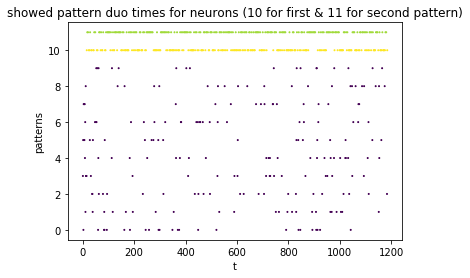

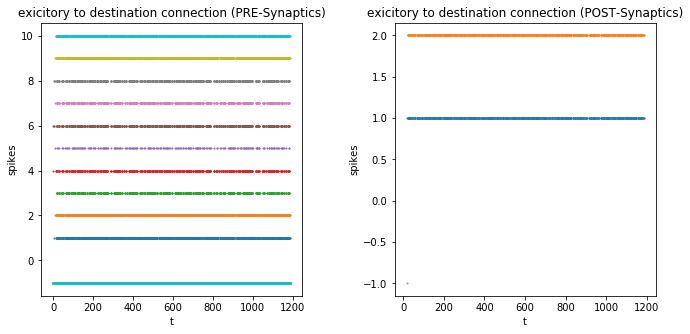

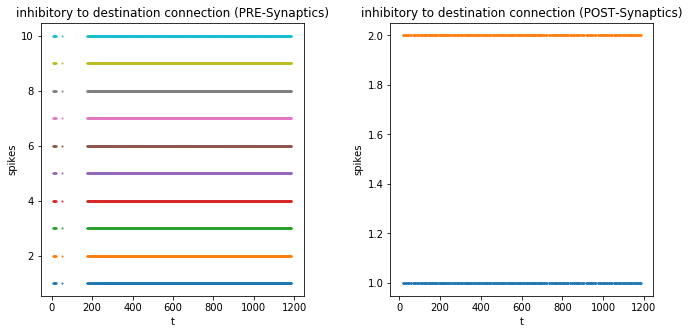

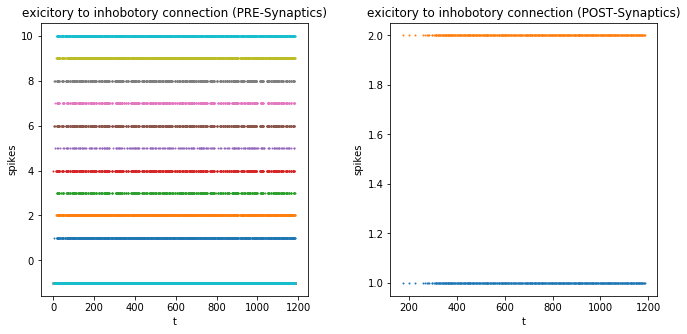

In [18]:
fig, ax = plt.subplots(1,1)
x= np.array(dic['patterns'])
c = x[:,1].copy()
c[c<10] = 0
c[c==10]=14
c[c==11]=12
spike_plotter(x[:,0], x[:,1], 
              xlabel='t', ylabel='patterns', 
              title="showed pattern duo times for neurons (10 for first & 11 for second pattern)", 
              c=c, ax=ax)

# -----------------------------------------------------------------------------------------------
pre_post_spikes(dic['dw_dt_ed'], title="exicitory to destination connection")
pre_post_spikes(dic['dw_dt_id'], title="inhibitory to destination connection")
pre_post_spikes(dic['dw_dt_ei'], title="exicitory to inhobotory connection")

In [64]:
p = (0.1, 0.25, 0.5)[0]
n = (2, 5, 10, 20)[3]

def unique_pattern(size, n):
    patterns = []
    for _ in range(n):
        rand = np.random.random(size)
        res  = np.ones_like(rand)
        res[rand < 0.3] = 0
        res[rand >= 0.6] = 2
        patterns.append(res)
    return patterns

config = {'timeStep': 0.01}
config['duration'] = (1+sum(max(pattern) for pattern in patterns)) * config['timeStep']
ecx_neuron_configs = {'tau': 5, 'resistor': 5,'threshold': -60, 'uRest': -75, 'noise': {'mu': 0, 'sigma': 2}}
inh_neuron_configs = {'tau': 5, 'resistor': 5,'threshold': -60, 'uRest': -75, 'noise': {'mu': 0, 'sigma': 2}}
stdp_config = {'wMax': 50, 'wMin': 0, 'taup': 8,'taun': 6, 'etap': 0.4, 'etan': 0.5}

exc = Population(Neuron, ecx_neuron_configs, size=800, hasInhibition=False, **config)
inh = Population(Neuron, inh_neuron_configs, size=200, hasInhibition=False, **config)

connections = Connection.fixedNPP(exc.size, inh.size, p=p, J0=10, r0=5, wMax=stdp_config['wMax'], wMin=stdp_config['wMin'])
connections = connections[connections['pre'][np.random.choice(connections['pre'], 50)]]
synaptic_tag = np.ones_like(connections['w']) 
modulated = {'c': synaptic_tag, 'tau_c': 5}
dopamin = synaptic_tag.copy()
ci_connections = [connections['post'] == i for i in range(n)]


#     stdp_config_ed = {'wMax': 15, 'wMin': 0, 'taup': 8,'taun': 6, 'etap': 0.04, 'etan': 0.05},
#     stdp_config_id = {'wMax': 20, 'wMin': 0, 'taup': 8,'taun': 6, 'etap': 0.04, 'etan': 0.05},

#     srci_neuron_configs = {'tau': 5, 'resistor': 5,'threshold': -60, 'uRest': -75, 'noise': {'mu': 0, 'sigma': 1}},
#     dest_neuron_configs = {'tau': 5, 'resistor': 5, 'threshold': -60, 'uRest': -75, 'noise': {'mu': 0, 'sigma': 5}},
#     patterns=patterns, 
# ):
#     reset_global_random_seed()
#     config['duration'] = (1+sum(max(pattern) for pattern in patterns)) * config['timeStep']
#     srce  = Population(Neuron, srce_neuron_configs, size=srce_size, hasInhibition=False, **config)
#     srci  = Population(Neuron, srci_neuron_configs, size=srci_size, hasInhibition=True, **config)
#     dest  = Population(Neuron, dest_neuron_configs, size=dest_size, hasInhibition=False, **config)
    
#     connections_ei = 
#     connections_ed = Connection.full(srce.size, dest.size, J0=10, r0=5, wMax=stdp_config_ed['wMax'], wMin=stdp_config_ed['wMin'])
#     connections_id = Connection.full(srci.size, dest.size, J0=10, r0=5, wMax=stdp_config_id['wMax'], wMin=stdp_config_id['wMin'])



In [61]:
connections['post']

array([5, 3, 2, 5, 2, 2, 1, 8, 8, 2, 0, 5, 8, 8, 9, 7, 2, 6, 3, 8, 8, 9,
       8, 8, 8, 4, 4, 5, 2, 2, 9, 2, 7, 4, 6, 4, 6, 2, 3, 4, 5, 1, 5, 0,
       0, 7, 4, 9, 2, 9], dtype=uint16)

In [65]:
unique_pattern(50, 2)

[array([1., 2., 1., 2., 2., 2., 2., 1., 2., 2., 1., 0., 1., 2., 2., 2., 2.,
        1., 1., 2., 0., 1., 0., 0., 2., 1., 1., 1., 2., 0., 0., 0., 2., 0.,
        1., 0., 2., 0., 2., 0., 1., 1., 2., 2., 1., 2., 2., 2., 0., 2.]),
 array([1., 1., 2., 2., 2., 1., 2., 1., 0., 1., 0., 1., 1., 1., 1., 0., 2.,
        0., 2., 2., 2., 2., 0., 2., 0., 0., 2., 1., 1., 0., 2., 2., 0., 1.,
        0., 1., 2., 0., 2., 0., 1., 1., 1., 2., 0., 2., 0., 2., 0., 1.])]